# COMP SCI 7318 Deep Learning Fundamental - Assignment 2
Lalitphan Sae-teoh (a1932456)

In [1]:
pip install torchinfo

In [2]:
import random
import os
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import numpy as np

import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torchinfo import summary

## Download the dataset - CIFAR10

In [3]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, './data')

# extract the dataset
with tarfile.open('./data/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

100%|██████████| 135M/135M [00:04<00:00, 31.5MB/s]


## Explore the dataset
There are Train & Test folder
Total 60,000 images: 6,000/classes ()

In [4]:
data_dir = './data/cifar10'
directories = os.listdir(data_dir)
classes = os.listdir(data_dir + "/train")

for dir in directories:
  print(f"{dir.upper()} folder consists of : ")
  for cls in classes:
    print(str(cls) + ':', len(os.listdir(data_dir + f'/{dir}/' + cls)))
  print("-----------------------------------------------")

TEST folder consists of : 
cat: 1000
horse: 1000
frog: 1000
ship: 1000
airplane: 1000
truck: 1000
dog: 1000
deer: 1000
bird: 1000
automobile: 1000
-----------------------------------------------
TRAIN folder consists of : 
cat: 5000
horse: 5000
frog: 5000
ship: 5000
airplane: 5000
truck: 5000
dog: 5000
deer: 5000
bird: 5000
automobile: 5000
-----------------------------------------------


In [5]:
# Train dataset
train_data = ImageFolder(data_dir+'/train', transform=ToTensor())
print(f"Training Dataset Total: {len(train_data)} images")

class_names = train_data.classes

img, label = train_data[0]
print(f"Label: {class_names[label]}, " , f"Image Shape: {img.shape}")
img

Training Dataset Total: 50000 images
Label: airplane,  Image Shape: torch.Size([3, 32, 32])


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

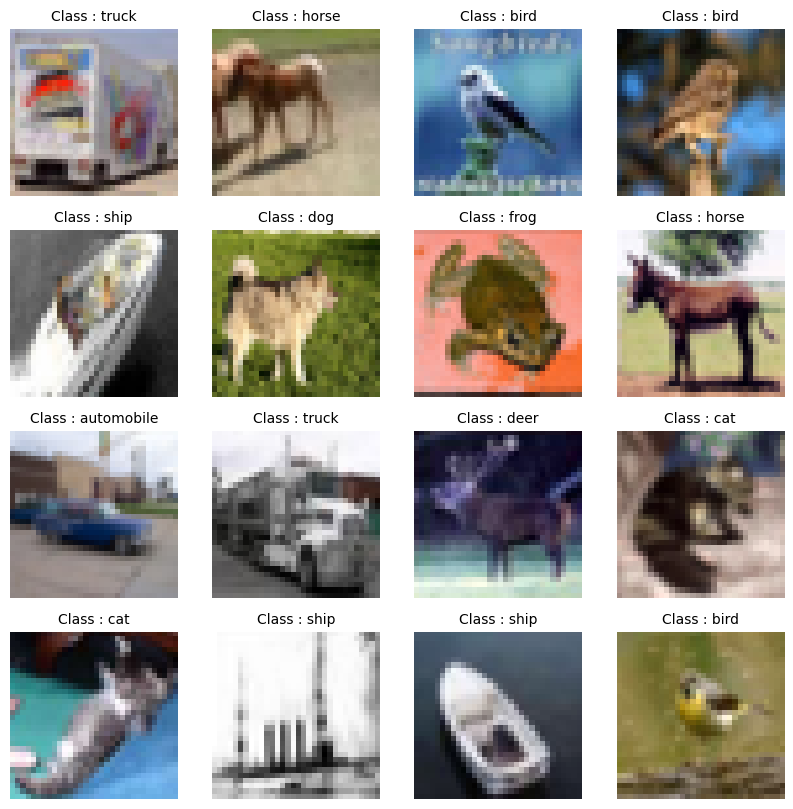

In [6]:
rand_idx = random.sample(range(len(train_data)),k=16)

plt.figure(figsize=(10,10))

for i , idx in enumerate(rand_idx):

  img , label = train_data[idx]

  #the image tensor's range is not between 0 and 1,so we have to temporarily scale the tensor values into range 0 and 1 to prevent error.
  img = (img - img.min()) / (img.max() - img.min())

  img_class = class_names[label]

  plt.subplot(4,4,i+1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"Class : {img_class}",fontsize=10)
  plt.axis(False)

## Pre-process Data

In [7]:
# random seed
random_seed = 2024
torch.manual_seed(random_seed)

val_size = 5000
train_size = len(train_data) - val_size

train_ds, val_ds = random_split(train_data, [train_size, val_size])
print(f"Total Train Split: {len(train_ds)}")
train_classes = [classes for data,classes in train_ds]
for i in range(10):
  print(f"Label {class_names[i]}: {train_classes.count(i)}")

print("-----------------------------------------")
print(f"Total Validation Split: {len(val_ds)}")
val_classes = [classes for data,classes in val_ds]
for i in range(10):
  print(f"Label {class_names[i]}: {val_classes.count(i)}")

Total Train Split: 45000
Label airplane: 4495
Label automobile: 4488
Label bird: 4519
Label cat: 4538
Label deer: 4491
Label dog: 4518
Label frog: 4495
Label horse: 4475
Label ship: 4480
Label truck: 4501
-----------------------------------------
Total Validation Split: 5000
Label airplane: 505
Label automobile: 512
Label bird: 481
Label cat: 462
Label deer: 509
Label dog: 482
Label frog: 505
Label horse: 525
Label ship: 520
Label truck: 499


In [8]:
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

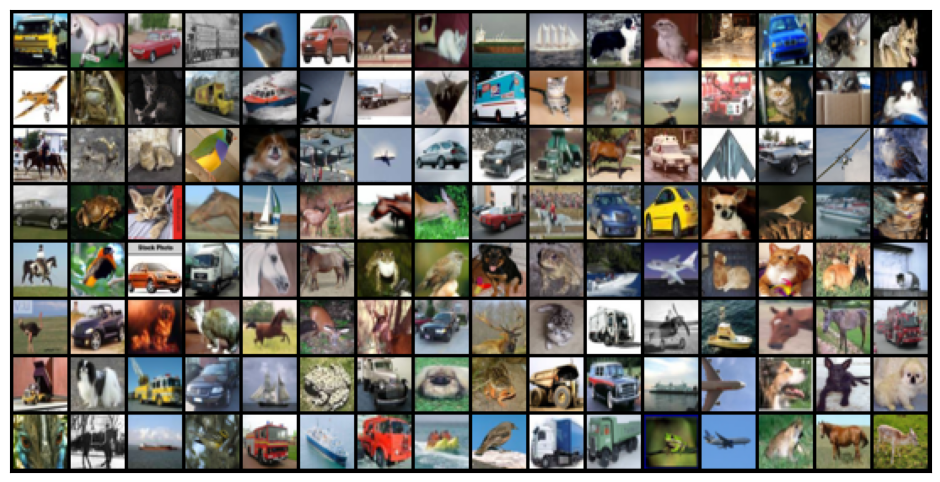

In [10]:
show_batch(train_dl)

## Define Model

In [11]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [12]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {'train_loss': loss, 'train_acc': acc}

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class BasicBlock(ImageClassificationBase):
    expansion = 1


    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(ImageClassificationBase):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [15]:
# class Cifar10CnnModel(ImageClassificationBase):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
#             # First Convolutional Layer
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Second Convolutional Layer
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Third Convolutional Layer
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Flatten layer
#             nn.Flatten(),

#             # Fully Connected Layers
#             nn.Linear(128 * 4 * 4, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 10))  # CIFAR-10 has 10 classes

#     def forward(self, xb):
#         return self.network(xb)

In [16]:
model = ResNet18()
# model

In [17]:
summary(model, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─Sequential: 1-3                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─Dropout: 3-3                 [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─Dropout: 3-6                 [1, 64, 32, 32]           --
│    │    └─Sequential: 3-7              [1, 64, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 64, 32, 32]           --
│

In [18]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images.to(next(model.parameters()).device))
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-2.1308, -1.5775, -2.3456, -2.4341, -2.1128, -2.6521, -2.6389, -2.7293,
        -2.5332, -2.4795], device='cuda:0', grad_fn=<SelectBackward0>)


## Model Helper

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

## Model Training

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accuracies = []

        for batch in train_loader:
            model_train = model.training_step(batch)
            train_accuracies.append(model_train['train_acc'])
            loss = model_train['train_loss']
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
model = to_device(ResNet18(), device)

In [24]:
evaluate(model, val_dl)

{'val_loss': 2.3014705181121826, 'val_acc': 0.10087315738201141}

## Optimize the model - Tuning hyperparameter

In [25]:
num_epochs = 10
# opt_func = torch.optim.Adam
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

history = fit(num_epochs, model, train_dl, val_dl, optimizer)

Epoch [0], train_loss: 1.3723, train_acc: 0.4998, val_loss: 1.5430, val_acc: 0.4918
Epoch [1], train_loss: 0.8901, train_acc: 0.6843, val_loss: 0.8731, val_acc: 0.6959
Epoch [2], train_loss: 0.6791, train_acc: 0.7592, val_loss: 0.7821, val_acc: 0.7339
Epoch [3], train_loss: 0.5433, train_acc: 0.8093, val_loss: 0.6572, val_acc: 0.7761
Epoch [4], train_loss: 0.4537, train_acc: 0.8426, val_loss: 0.6408, val_acc: 0.7889
Epoch [5], train_loss: 0.3809, train_acc: 0.8678, val_loss: 0.6322, val_acc: 0.7967
Epoch [6], train_loss: 0.3121, train_acc: 0.8904, val_loss: 0.6953, val_acc: 0.7847
Epoch [7], train_loss: 0.2584, train_acc: 0.9104, val_loss: 0.4857, val_acc: 0.8422
Epoch [8], train_loss: 0.2007, train_acc: 0.9288, val_loss: 0.5776, val_acc: 0.8275
Epoch [9], train_loss: 0.1713, train_acc: 0.9392, val_loss: 0.5900, val_acc: 0.8334


In [26]:
# function to plot loss & accuracy curve

def plot_loss_curves(results):

    loss = [x['train_loss'] for x in results]
    val_loss = [x['val_loss'] for x in results]
    train_accuracy = [x['train_acc'] for x in results]
    val_accuracy = [x['val_acc'] for x in results]

    # Figure out how many epochs there were
    epochs = range(len(loss))

    # Setup a plot
    plt.figure(figsize=(10, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

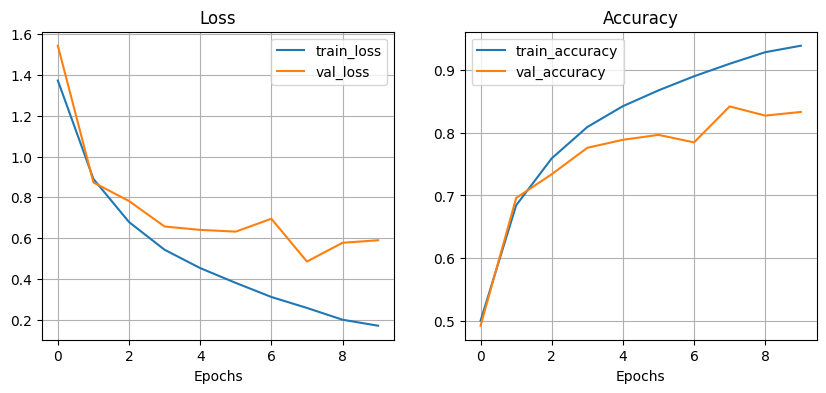

In [27]:
plot_loss_curves(history)

In [28]:
num_epochs = 10
learning_rate = 0.001
weight_decay = 0.0001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

history_tuning = fit(num_epochs, model, train_dl, val_dl, optimizer)

Epoch [0], train_loss: 0.1875, train_acc: 0.9320, val_loss: 0.6047, val_acc: 0.8293
Epoch [1], train_loss: 0.1876, train_acc: 0.9337, val_loss: 0.6067, val_acc: 0.8201
Epoch [2], train_loss: 0.1964, train_acc: 0.9311, val_loss: 0.6324, val_acc: 0.8119
Epoch [3], train_loss: 0.1780, train_acc: 0.9379, val_loss: 0.8647, val_acc: 0.7716
Epoch [4], train_loss: 0.1703, train_acc: 0.9411, val_loss: 0.5567, val_acc: 0.8346
Epoch [5], train_loss: 0.1595, train_acc: 0.9432, val_loss: 0.6898, val_acc: 0.8191
Epoch [6], train_loss: 0.1582, train_acc: 0.9443, val_loss: 0.5626, val_acc: 0.8366
Epoch [7], train_loss: 0.1473, train_acc: 0.9486, val_loss: 0.5471, val_acc: 0.8368
Epoch [8], train_loss: 0.1309, train_acc: 0.9543, val_loss: 0.6312, val_acc: 0.8213
Epoch [9], train_loss: 0.1314, train_acc: 0.9534, val_loss: 0.5851, val_acc: 0.8413


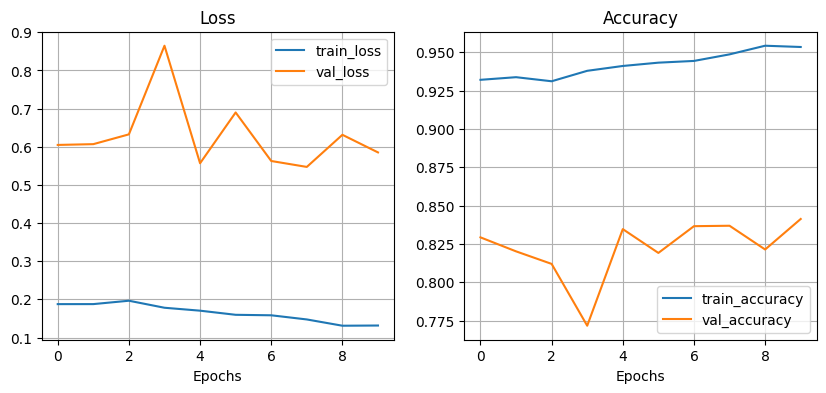

In [29]:
plot_loss_curves(history_tuning)

## Testing with individual image

In [30]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [31]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return class_names[preds[0].item()]

Label: airplane , Predicted: airplane


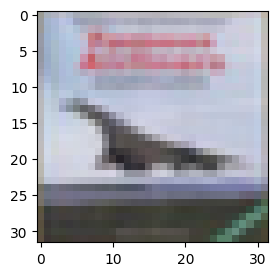

In [32]:
img, label = test_dataset[0]
plt.figure(figsize=(5,3))
plt.imshow(img.permute(1, 2, 0))
print('Label:', class_names[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


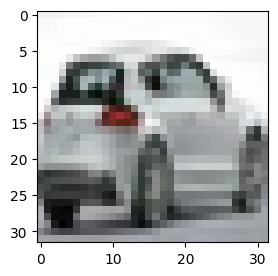

In [33]:
img, label = test_dataset[1010]
plt.figure(figsize=(5,3))
plt.imshow(img.permute(1, 2, 0))
print('Label:', class_names[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


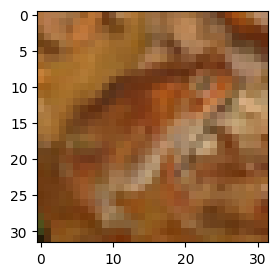

In [34]:
img, label = test_dataset[6200]
plt.figure(figsize=(5,3))
plt.imshow(img.permute(1, 2, 0))
print('Label:', class_names[label], ', Predicted:', predict_image(img, model))

In [35]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.5932803153991699, 'val_acc': 0.832714855670929}

<Axes: >

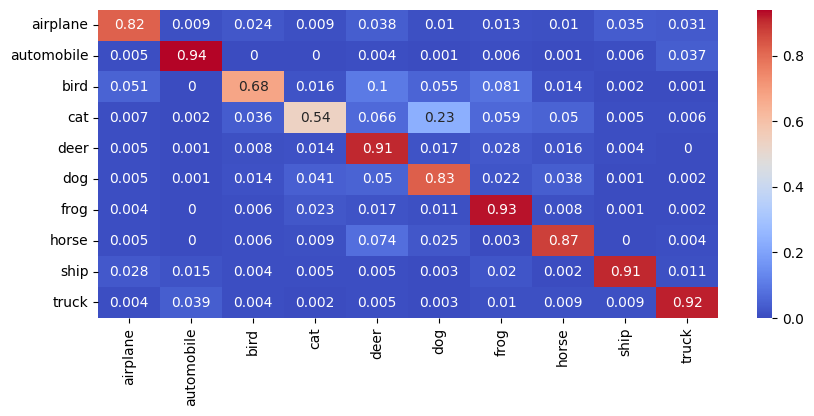

In [36]:
## Try predicting images with our model

predicted_labels = []
actual_labels = []

model.eval()

with torch.no_grad():  # We are using no_grad instead of inference_mode for better compatibility
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    # prediction_logits = model(images.to(next(model.parameters()).device))
    prediction_logits = model(images)
    predictions = prediction_logits.argmax(dim=1).cpu().numpy()
    predicted_labels.extend(predictions)
    true_labels = labels.cpu().numpy()
    actual_labels.extend(true_labels)

confusion_mat = confusion_matrix(actual_labels, predicted_labels)
confusion_df = pd.DataFrame(confusion_mat/np.sum(confusion_mat)*10, index=class_names, columns=class_names)
plt.figure(figsize=(10,4))
sn.heatmap(confusion_df, annot=True, cmap="coolwarm")

# Hyperparameter Tuning

In [37]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [38]:
import optuna
import torch.optim as optim

def objective(trial):
    # Suggest hyperparameters
    batch_size = trial.suggest_int('batch_size', 16, 64)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)

    # DataLoader
    # train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    # model = resnet18(pretrained=True)
    # model.fc = nn.Linear(in_features, 10)  # CIFAR-10 has 10 classes
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model.to(device)
    model = to_device(ResNet18(), device)
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)
    to_device(model, device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    num_epochs = 10

    # Training loop
    # history = fit(num_epochs, lr, model, train_dl, val_dl, optimizer)
    model.train()
    for epoch in range(10):  # Adjust number of epochs as needed
        running_loss = 0.0
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [39]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Display the best hyperparameters and accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-11-09 07:13:31,893] A new study created in memory with name: no-name-09022c35-06f5-4d7e-9149-7b860719293e
<ipython-input-38-cc11740d62f7>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-38-cc11740d62f7>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
<ipython-input-38-cc11740d62f7>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
[I 202

Best hyperparameters: {'batch_size': 17, 'lr': 0.003288412243897748, 'momentum': 0.9696762529817456, 'weight_decay': 0.0003462693256683396}
Best accuracy: 0.8372


In [40]:
def objective_adam(trial):
    # Suggest hyperparameters
    batch_size = trial.suggest_int('batch_size', 16, 64)
    # batch_size = 128
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)

    # DataLoader
    # train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    # model = resnet18(pretrained=True)
    # model.fc = nn.Linear(in_features, 10)  # CIFAR-10 has 10 classes
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model.to(device)
    model = to_device(ResNet18(), device)
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)
    to_device(model, device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    num_epochs = 10

    # Training loop
    # history = fit(num_epochs, lr, model, train_dl, val_dl, optimizer)
    model.train()
    for epoch in range(10):  # Adjust number of epochs as needed
        running_loss = 0.0
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [41]:
# Create an Optuna study
study_2 = optuna.create_study(direction='maximize')
study_2.optimize(objective_adam, n_trials=10)

# Display the best hyperparameters and accuracy
print("Best hyperparameters:", study_2.best_params)
print("Best accuracy:", study_2.best_value)

[I 2024-11-09 07:55:50,796] A new study created in memory with name: no-name-8197cf20-ba78-4b94-b0e0-c76e9b702a3f
<ipython-input-40-a13f346d2576>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-40-a13f346d2576>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
[I 2024-11-09 08:00:23,254] Trial 0 finished with value: 0.1688 and parameters: {'batch_size': 26, 'lr': 0.0009297073732397729, 'weight_decay': 0.07924401504818551}. Best is trial 0 with value: 0.1688.
[I 2024-11-09 08:03:59,071] Trial 1 finished with value: 0.7766 and parameters: {'ba

Best hyperparameters: {'batch_size': 46, 'lr': 5.961717804701843e-05, 'weight_decay': 1.707423986872216e-05}
Best accuracy: 0.8254
